In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from viz import raster_evidence_geomap
from features import lat_lng2dist_ang
from cmdstanpy import CmdStanModel, set_cmdstan_path
import os
import arviz as az
sns.set_theme()

GEOLOCATION="unil"
TRANSFORMED_CSV = f"datasets/processed/{GEOLOCATION}/transformed.csv"
GT_POINTS_CSV = f"datasets/raw/{GEOLOCATION}/gt_points.csv"
CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
STAN_MODEL_PATH = 'bivariate_normal_corr.stan'

set_cmdstan_path(CMDSTAN_PATH)


transformed_df = pd.read_csv(TRANSFORMED_CSV)
gt_points_df = pd.read_csv(GT_POINTS_CSV)
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
transformed_df["plot_label"] = transformed_df["measured_from"] + " (measured)"
proposal_names = gt_points_df["name"].tolist()
proposal_names.remove("E")
proposal_names

# TODO: consider precise

['P1', 'P2']

<Axes: xlabel='lng', ylabel='lat'>

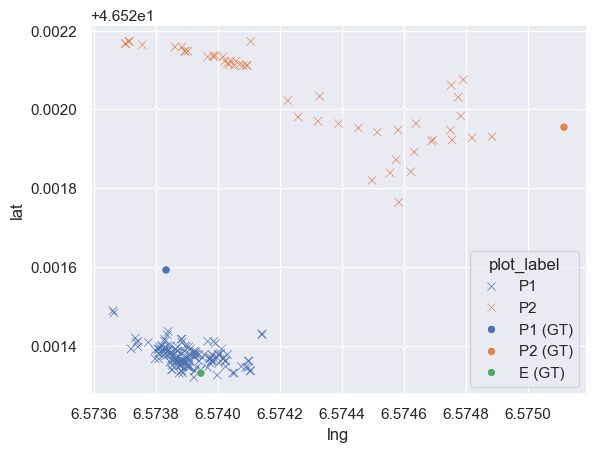

In [77]:
# visualize

fig, ax = plt.subplots()
sns.scatterplot(data=transformed_df, x='lng', y='lat', hue='measured_from', ax=ax, marker='x')
gt_points_df["plot_label"] = gt_points_df["name"] + " (GT)"
sns.scatterplot(data=gt_points_df, x='lng', y='lat', hue='plot_label', ax=ax)

In [78]:
gt_points_df

,name,lat,lng,plot_label
0,P1,46.521592,6.573832,P1 (GT)
1,P2,46.521955,6.575116,P2 (GT)
2,E,46.521331,6.573944,E (GT)


In [79]:
transformed_df

,measured_from,lat,lng,distance,angle_rad,angle_deg,plot_label
0,P1,46.521344,6.573931,28.567320,2.873785,164.655746,P1 (measured)
1,P1,46.521408,6.573775,20.910190,3.352463,192.082006,P1 (measured)
2,P1,46.521381,6.573844,23.554072,3.101168,177.683850,P1 (measured)
3,P1,46.521361,6.573889,26.063941,2.973435,170.365252,P1 (measured)
4,P1,46.521386,6.573825,22.923629,3.165157,181.350112,P1 (measured)
...,...,...,...,...,...,...,...
195,P2,46.521892,6.574633,37.719201,4.525284,259.279701,P2 (measured)
196,P2,46.521919,6.574689,33.032434,4.593177,263.169673,P2 (measured)
197,P2,46.521922,6.574756,27.918201,4.582366,262.550258,P2 (measured)
198,P2,46.521928,6.574819,22.977217,4.581353,262.492195,P2 (measured)


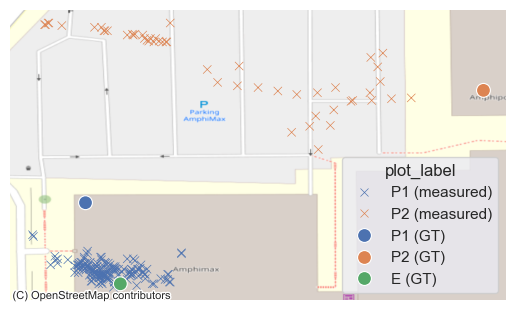

In [80]:
ax = raster_evidence_geomap(gt_points_df, transformed_df)

In [81]:


P1_lat, P1_lng = gt_points_df[gt_points_df['name'] == 'P1'][['lat', 'lng']].values[0].tolist()
P2_lat, P2_lng = gt_points_df[gt_points_df['name'] == 'P2'][['lat', 'lng']].values[0].tolist()
E_lat, E_lng = gt_points_df[gt_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist()
E_P1_dist, E_P1_angle_rad, E_P1_angle_deg = lat_lng2dist_ang([P1_lat, P1_lng], [E_lat, E_lng])
E_P2_dist, E_P2_angle_rad, E_P2_angle_deg = lat_lng2dist_ang([P2_lat, P2_lng], [E_lat, E_lng])

print(f"P1: {P1_lat}, {P1_lng}")
print(f"P2: {P2_lat}, {P2_lng}")
print(f"E: {E_lat}, {E_lng}")
print(f"E using P1 as the center: dist={E_P1_dist}, angle_rad={E_P1_angle_rad}, angle_deg={E_P1_angle_deg}")
print(f"E using P2 as the center: dist={E_P2_dist}, angle_rad={E_P2_angle_rad}, angle_deg={E_P2_angle_deg}")


P1: 46.521592273, 6.573832039
P2: 46.521954786, 6.575116326
E: 46.521330555, 6.573944444
E using P1 as the center: dist=30.344572744546294, angle_rad=2.8533795973322875, angle_deg=163.48660827587835
E using P2 as the center: dist=113.5817863518005, angle_rad=4.055162326777971, angle_deg=232.34368656482852


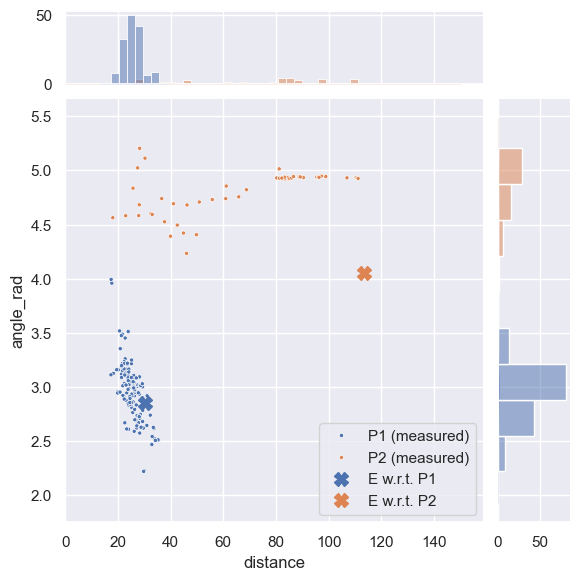

In [82]:
#! P1(measured) and P2(measured) are measurements that are transformed to dist and angle WITH RESPECT TO THEIR GROUND TRUTH (P1 or P2)
g = sns.jointplot(
        data=transformed_df,
        x="distance",
        y="angle_rad",
        hue="plot_label",
        kind="scatter",
        marginal_ticks=True,
        joint_kws={"marker": "."},
        # alpha=0.5
    )

# lower bound for distance is 0
g.ax_joint.set_xlim(left=0)
g.plot_marginals(sns.histplot)


for proposal_name in proposal_names:
    proposal_lat_lng = gt_points_df[gt_points_df["name"] == proposal_name][["lat", "lng"]].values[0]
    dist, angle_rad, _ = lat_lng2dist_ang(proposal_lat_lng, [E_lat, E_lng])
    g.ax_joint.plot(dist, angle_rad, 'X', label=f"E w.r.t. {proposal_name}", markersize=10)
g.ax_joint.legend()

In [83]:
def visualize_polar(measurements_df, gt_points_df):
    fig, ax = plt.subplots(1, gt_points_df.shape[0] - 1, subplot_kw=dict(polar=True))
    # meters and degrees
    for i, row in gt_points_df.iterrows():
        if row["name"] == "E":
            continue
        proposal_name = row["name"]
        proposal_data = measurements_df[measurements_df["measured_from"] == proposal_name]
        ax[i].scatter(proposal_data["angle_rad"], proposal_data["dist"], label=proposal_name)
        ax[i].set_title(proposal_name)
        ax[i].set_ylim(0, 100)
        ax[i].set_yticks([0, 25, 50, 75, 100])

    return ax

# visualize_polar(measurements_df, gt_points_df) # TODO: improve this for the paper

In [85]:
stan_data = {
    "N1": transformed_df[transformed_df["measured_from"] == "P1"].shape[0],
    "N2": transformed_df[transformed_df["measured_from"] == "P2"].shape[0],
    "y1": transformed_df[transformed_df["measured_from"] == "P1"][["distance", "angle_rad"]].values.tolist(),
    "y2": transformed_df[transformed_df["measured_from"] == "P2"][["distance", "angle_rad"]].values.tolist(),
    "E_p1": [E_P1_dist, E_P1_angle_rad],
    "E_p2": [E_P2_dist, E_P2_angle_rad]
}
model = CmdStanModel(stan_file=STAN_MODEL_PATH)
fit = model.sample(data=stan_data,
                        chains=4,
                        iter_warmup=1000,
                        iter_sampling=4000,
                        seed=1,
                        parallel_chains=os.cpu_count()
)

display(fit.summary())
print(fit.diagnose())

17:40:34 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
17:40:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▍         | 00:00 Iteration:    1 / 5000 [  0%]  (Warmup)


chain 1 |▊         | 00:00 Iteration:  200 / 5000 [  4%]  (Warmup)


chain 1 |█▏        | 00:00 Iteration:  400 / 5000 [  8%]  (Warmup)


chain 1 |█▋        | 00:00 Iteration:  700 / 5000 [ 14%]  (Warmup)

chain 1 |██        | 00:01 Iteration:  900 / 5000 [ 18%]  (Warmup)


chain 1 |██▋       | 00:01 Iteration: 1100 / 5000 [ 22%]  (Sampling)


chain 1 |███       | 00:01 Iteration: 1300 / 5000 [ 26%]  (Sampling)


chain 1 |███▍      | 00:01 Iteration: 1500 / 5000 [ 30%]  (Sampling)


chain 1 |███▊      | 00:01 Iteration: 1700 / 5000 [ 34%]  (Sampling)


chain 1 |████▏     | 00:02 Iteration: 1900 / 5000 [ 38%]  (Sampling)


chain 1 |████▌     | 00:02 Iteration: 2100 / 5000 [ 42%]  (Sampling)


chain 1 |█████     | 00


17:40:39 - cmdstanpy - INFO - CmdStan done processing.
17:40:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in 'bivariate_normal_corr.stan', line 45, column 2 to column 33)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in 'bivariate_normal_corr.stan', line 45, column 2 to column 33)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -nan. (in 'bivariate_normal_corr.stan', line 45, column 2 to column 33)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf, but Covariance matrix[2,1] = inf (in 'bivariate_normal_corr.stan', line 46, column 2 to column 33)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = inf,

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-251.29200,0.025725,2.227450,-255.35900,-250.97600,-248.25900,7497.27,509.084,1.000160
mu1[1],25.68730,0.002541,0.292343,25.20660,25.68820,26.16740,13235.30,898.712,0.999922
mu1[2],2.94750,0.000187,0.021639,2.91210,2.94748,2.98330,13392.20,909.361,0.999997
mu2[1],57.79330,0.036269,4.000160,51.03250,57.94630,64.15660,12164.20,825.977,1.000310
mu2[2],4.77523,0.000268,0.030335,4.72546,4.77549,4.82433,12840.30,871.887,1.000200
...,...,...,...,...,...,...,...,...,...
"y2_rep[49,2]",4.77456,0.001688,0.206993,4.43367,4.77511,5.11358,15032.10,1020.720,0.999924
"y2_rep[50,1]",57.69510,0.228876,28.688600,10.23450,57.93300,104.31400,15711.60,1066.860,0.999805
"y2_rep[50,2]",4.77434,0.001723,0.210526,4.42945,4.77420,5.12062,14932.60,1013.960,0.999929
"y2_rep[51,1]",57.88900,0.228973,28.703000,10.38960,58.24320,104.45600,15714.00,1067.020,0.999959


Processing csv files: /tmp/tmp8qekpzoy/bivariate_normal_corrv5dohjvk/bivariate_normal_corr-20240824174034_1.csv, /tmp/tmp8qekpzoy/bivariate_normal_corrv5dohjvk/bivariate_normal_corr-20240824174034_2.csv, /tmp/tmp8qekpzoy/bivariate_normal_corrv5dohjvk/bivariate_normal_corr-20240824174034_3.csv, /tmp/tmp8qekpzoy/bivariate_normal_corrv5dohjvk/bivariate_normal_corr-20240824174034_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [110]:
replicate_datasets_p1 = fit.y1_rep # n_draws x n_measurements_p1 x 2 (distance, angle_rad)
print(replicate_datasets_p1.shape)
replicate_datasets_p2 = fit.y2_rep # n_draws x n_measurements_p2 x 2 (distance, angle_rad)
print(replicate_datasets_p2.shape)

# randomly select 5 replicate datasets for each proposal
n_replicates = 5
replicate_indices = np.random.choice(replicate_datasets_p1.shape[0], n_replicates, replace=False)
replicate_datasets_p1 = replicate_datasets_p1[replicate_indices]
replicate_datasets_p2 = replicate_datasets_p2[replicate_indices]
print(replicate_datasets_p1.shape)
print(replicate_datasets_p2.shape)


(16000, 149, 2)
(16000, 51, 2)
(5, 149, 2)
(5, 51, 2)


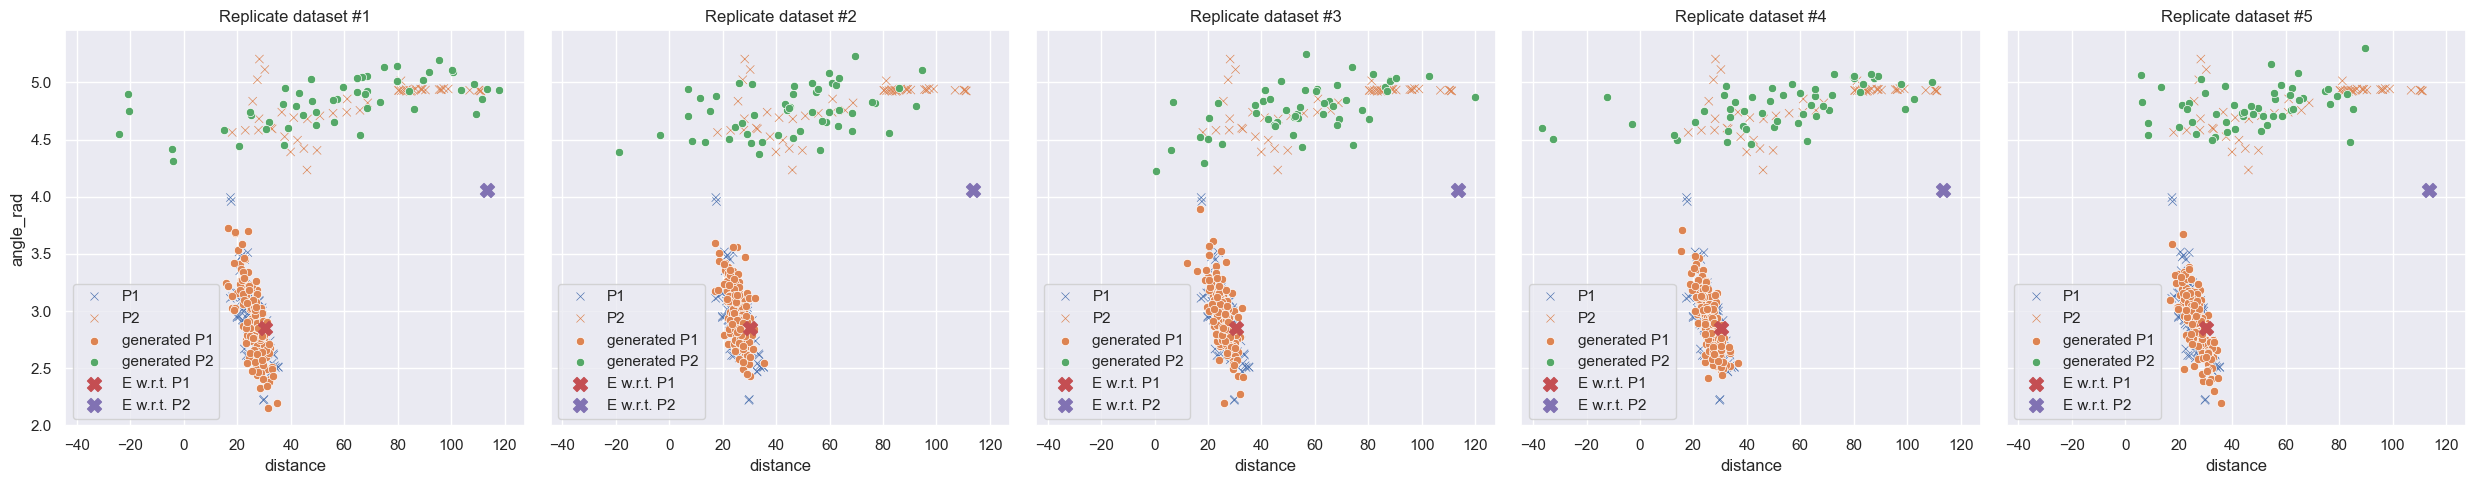

In [127]:
# plot the posterior predictive
# TODO: sort out the colors
fig, ax = plt.subplots(1, n_replicates, figsize=(n_replicates * 5, 5), sharex=True, sharey=True)
for i in range(n_replicates):
    sns.scatterplot(data=transformed_df, x='distance', y='angle_rad', hue='measured_from', ax=ax[i], marker='x')
    sns.scatterplot(data=pd.DataFrame(replicate_datasets_p1[i], columns=["distance", "angle_rad"]), x='distance', y='angle_rad', ax=ax[i], label="generated P1")
    sns.scatterplot(data=pd.DataFrame(replicate_datasets_p2[i], columns=["distance", "angle_rad"]), x='distance', y='angle_rad', ax=ax[i], label="generated P2")
    ax[i].scatter(E_P1_dist, E_P1_angle_rad, label="E w.r.t. P1", marker='X', s=100)
    ax[i].scatter(E_P2_dist, E_P2_angle_rad, label="E w.r.t. P2", marker='X', s=100)
    ax[i].set_title(f"Replicate dataset #{i + 1}")
    ax[i].set_xlabel("distance")
    ax[i].set_ylabel("angle_rad")
    ax[i].legend()

plt.tight_layout()  


/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'Sigma1\n0, 0'}>,
        <Axes: title={'center': 'Sigma1\n0, 0'}>],
       [<Axes: title={'center': 'Sigma1\n0, 1'}>,
        <Axes: title={'center': 'Sigma1\n0, 1'}>],
       [<Axes: title={'center': 'Sigma1\n1, 0'}>,
        <Axes: title={'center': 'Sigma1\n1, 0'}>],
       [<Axes: title={'center': 'Sigma1\n1, 1'}>,
        <Axes: title={'center': 'Sigma1\n1, 1'}>],
       [<Axes: title={'center': 'Sigma2\n0, 0'}>,
        <Axes: title={'center': 'Sigma2\n0, 0'}>],
       [<Axes: title={'center': 'Sigma2\n0, 1'}>,
        <Axes: title={'center': 'Sigma2\n0, 1'}>],
       [<Axes: title={'center': 'Sigma2\n1, 0'}>,
        <Axes: title={'center': 'Sigma2\n1, 0'}>],
       [<Axes: title={'center': 'Sigma2\n1, 1'}>,
        <Axes: title={'center': 'Sigma2\n1, 1'}>],
       [<Axes: title={'center': 'log_lik1'}>,
        <Axes: title={'center': 'log_lik1'}>],
       [<Axes: title={'center': 'log_lik2'}>,
        <Axes: title={'center': 'log_lik2'}>],
      

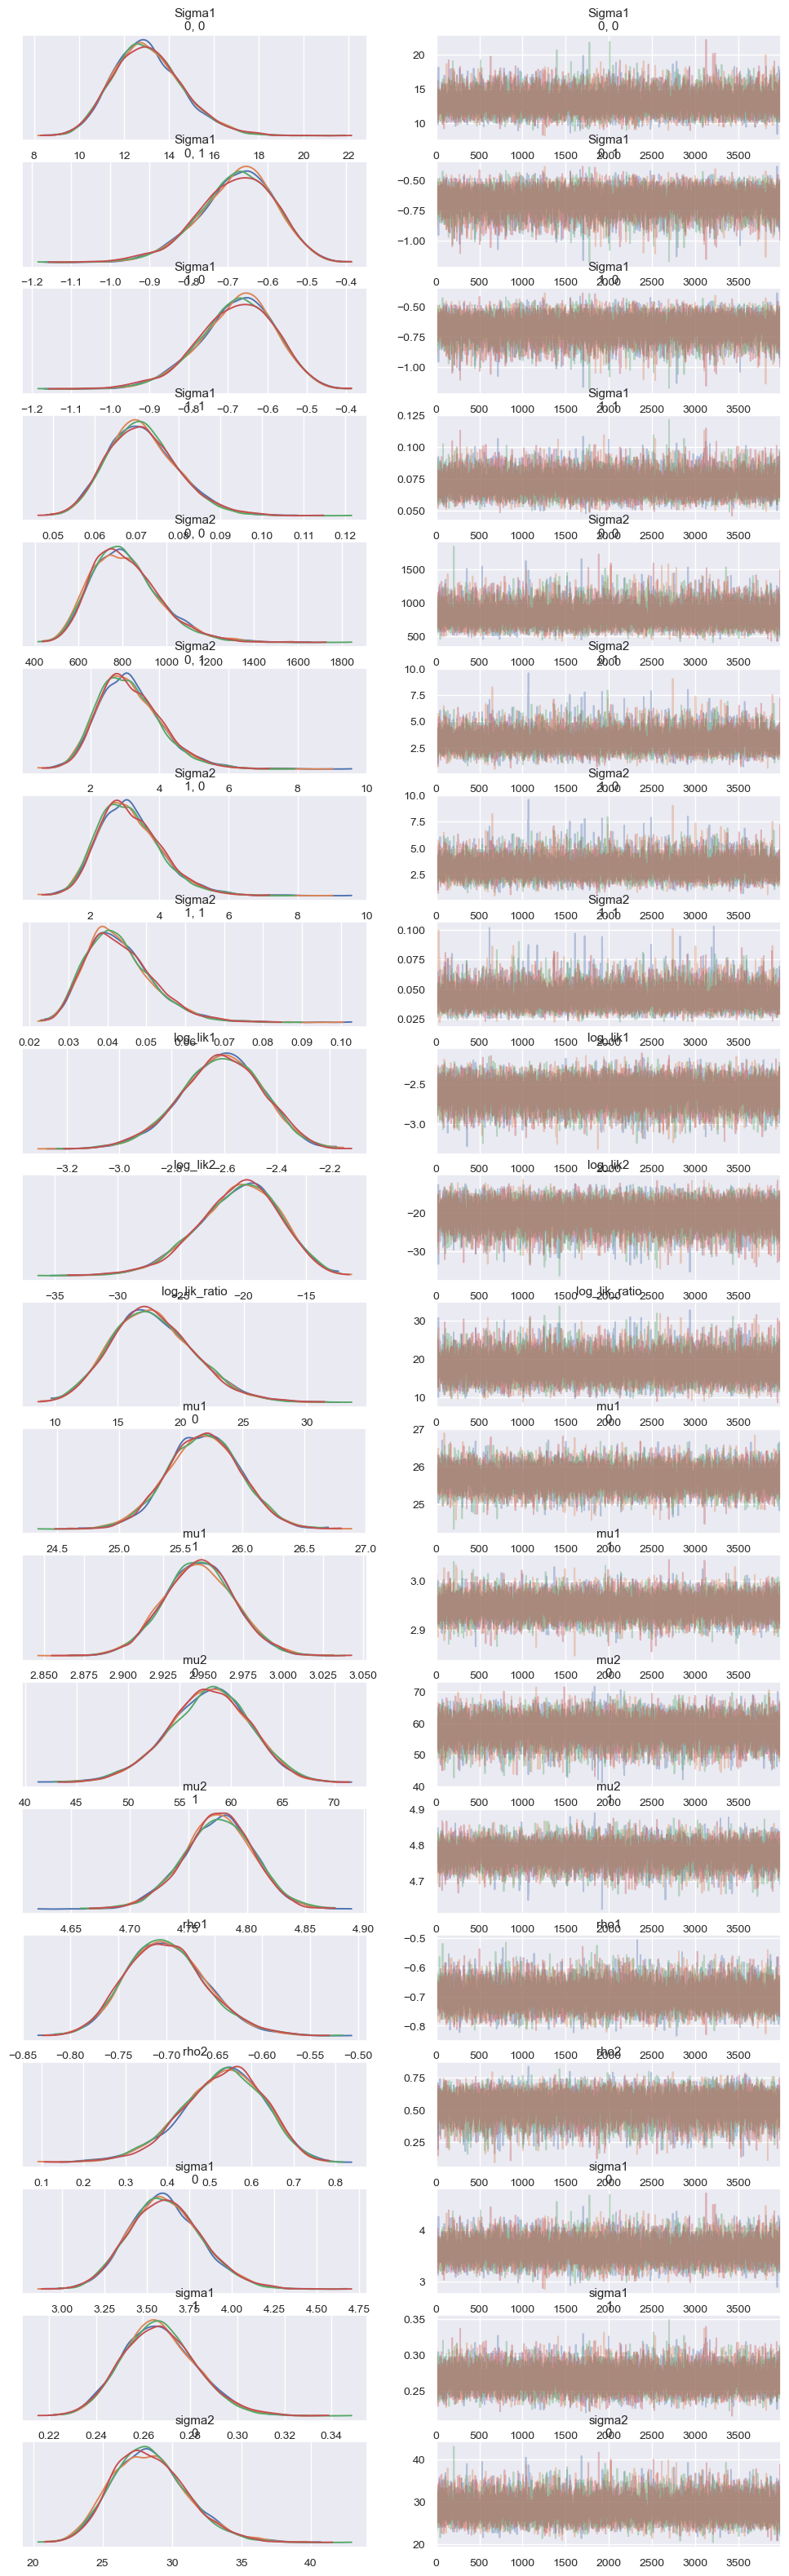

In [25]:
# TODO: filter trace variables
# az.plot_trace(fit, compact=False)

In [93]:
log_lik_ratio = fit.log_lik_ratio
# mean lr +- mcse
mean_lr = np.mean(log_lik_ratio)
mcse_lr = az.stats.mcse(log_lik_ratio)

print(f"Mean log likelihood ratio: {mean_lr} +- {mcse_lr}, 95% HDI: {az.hdi(log_lik_ratio, hdi_prob=0.95)}")

Mean log likelihood ratio: 17.84098695625 +- 0.020259027760710757, 95% HDI: [11.8376 24.5493]
